# 22.46 Procesamiento Adaptativo de Señales Aleatorias
## Trabajo Práctico N° 1
## Estimación espectral no-paramétrica
Se busca analizar la señal gravitatoria **GW150914** detectada por el proyecto **LIGO** el 14 de septiembre de 2015. Para ello, se realiza primero un análisis y estudio de la señal capturada por los sensores, y a partir de las conclusiones obtenidas y la información extraída, se propone un filtrado que permita obtener las señales con el menor ruido posible.

#### Grupo N° 1
* Kammann, Lucas Agustín
* Trozzo, Rafael Nicolás
* Davidov, Gonzalo Joaquín
* Farall, Facundo David

In [1]:
import seaborn as sns

In [2]:
sns.set_style('dark')
sns.set_context('paper')
sns.set_palette('flare')

## Descargando muestras de la señal
Se procede a descargar las muestras de la señal obtenidas por los sensores, se descargan con una frecuencia de muestreo $f_s = 4kHz$, en extensión temporal de $32 s$ y $4096 s$.

In [3]:
import wget

In [4]:
import os

In [12]:
# Create a dictionary with filenames
filepath= {
    'H1': {
        '32': '../resources/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5',
        '4096': '../resources/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    },
    'L1': {
        '32': '../resources/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5',
        '4096': '../resources/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5'
    }
}

In [17]:
# Create a resources/ folder
! cd .. & mkdir resources

In [18]:
# Download 4096 second data files around GW150914
if not os.path.exists(filepath['H1']['4096']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5
if not os.path.exists(filepath['L1']['4096']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


Saved under ../resources/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5

Saved under ../resources/L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [19]:
# Download 32 second data files around GW150914
if not os.path.exists(filepath['H1']['32']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5
if not os.path.exists(filepath['L1']['32']):
    ! python -m wget -o ../resources https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5


Saved under ../resources/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5

Saved under ../resources/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5


## Decodificando archivos HDF5
Utilizando la biblioteca **h5py** se decodifican los archivo en formato **HDF5** para tener acceso a las muestras de las señales.

##### Fuentes de información
* https://cplberry.com/tag/losc/
* https://docs.h5py.org/en/stable/index.html
* https://www.gw-openscience.org/static/sample_code/readligo.py

In [21]:
import h5py

In [22]:
def read_data(filename: str) -> tuple:
    """ Extracts sampling information and the signal samples from the HDF5 file obtained
        using LIGO's sensors to detect the gravitational wave.
        @param filename Filename or filepath to read the HDF5 file
        @return (start, ts, sample)
        
        @note The start value returned is in GPS units, and it represents the starting time of the sequence
    """
    # Open the HDF5 file and extract the strain dataset
    file = h5py.File(filename, 'r')
    strain_dataset = file['strain/Strain']
    
    # Read the sampling time and the starting time
    ts = strain_dataset.attrs['Xspacing']
    start = strain_dataset.attrs['Xstart']
    
    # Read the samples
    samples = strain_dataset[:]
    
    return start, ts, samples

In [23]:
def get_event_info(data_start, data_sample_rate, event_start, event_duration):
    """ Get time information of the event, it basically converts the known absolute duration and start of the event
        to a value measured in data samples. Provides an easy way to locate the event in the data.
        @param data_start GPS starting time of the data sequence
        @param data_sample_rate Sampling rate
        @param event_start GPS starting time of the event
        @param event_duration Duration in seconds of the event
        @return (start, duration)
    """
    start = int((event_start - data_start) * data_sample_rate)
    duration = int(event_duration * data_sample_rate)
    return start, duration

In [24]:
# Read H1 data (both 32 and 4096 seconds of duration)
h1_32_start, h1_32_ts, h1_32_samples = read_data(filepath['H1']['32'])
h1_4096_start, h1_4096_ts, h1_4096_samples = read_data(filepath['H1']['4096'])

In [25]:
# Read L1 data (both 32 and 4096 seconds of duration)
l1_32_start, l1_32_ts, l1_32_samples = read_data(filepath['L1']['32'])
l1_4096_start, l1_4096_ts, l1_4096_samples = read_data(filepath['L1']['4096'])

In [26]:
event_start = 1126259462
event_duration = 200e-3

h1_32_ev_info = get_event_info(h1_32_start, 1 / h1_32_ts, event_start, event_duration)
h1_4096_ev_info = get_event_info(h1_4096_start, 1 / h1_4096_ts, event_start, event_duration)
l1_32_ev_info = get_event_info(l1_32_start, 1 / l1_32_ts, event_start, event_duration)
l1_4096_ev_info = get_event_info(l1_4096_start, 1 / l1_4096_ts, event_start, event_duration)

print('Ubicación y duración del evento')
print(f'Para H1 con 32s -> En {h1_32_ev_info[0]} y dura {h1_32_ev_info[1]} muestras')
print(f'Para H1 con 4096s -> En {h1_4096_ev_info[0]} y dura {h1_4096_ev_info[1]} muestras')
print(f'Para L1 con 32s -> En {l1_32_ev_info[0]} y dura {l1_32_ev_info[1]} muestras')
print(f'Para L1 con 4096s -> En {l1_4096_ev_info[0]} y dura {l1_4096_ev_info[1]} muestras')

Ubicación y duración del evento
Para H1 con 32s -> En 61440 y dura 819 muestras
Para H1 con 4096s -> En 8384512 y dura 819 muestras
Para L1 con 32s -> En 61440 y dura 819 muestras
Para L1 con 4096s -> En 8384512 y dura 819 muestras


## Visualización de señales originales
En esta sección se visualizan las señales originales obtenidas a partir de los sensores.

In [27]:
import matplotlib.pyplot as plt

In [28]:
import numpy as np

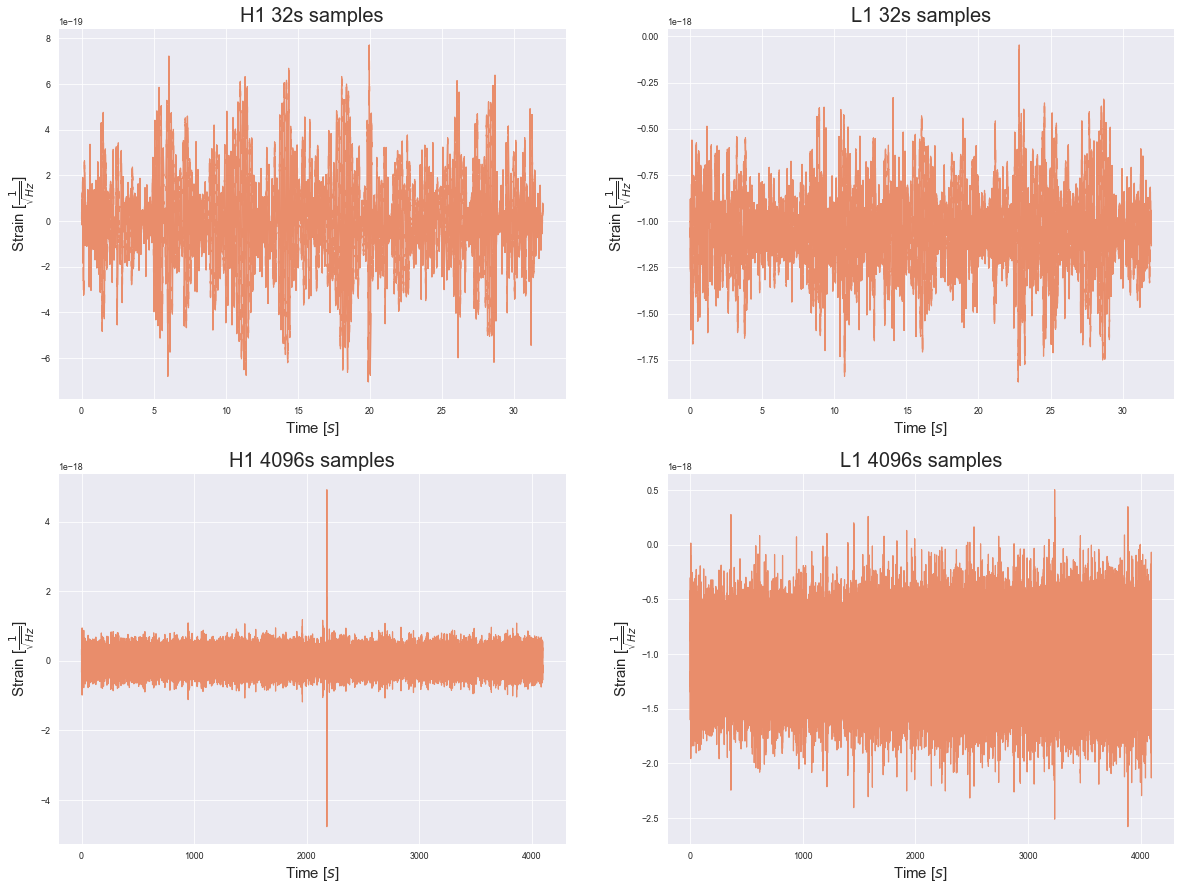

In [29]:
# Create four plotting areas to show L1 and H1 in both durations (32 and 4096 seconds)
fig, ax = plt.subplots(2, 2, figsize=(20, 15))

# Plot data
ax[0, 0].plot(np.arange(0, len(h1_32_samples) * h1_32_ts, h1_32_ts), h1_32_samples)
ax[0, 0].set_title('H1 32s samples', fontsize=20)
ax[0, 0].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[0, 0].set_xlabel('Time [$s$]', fontsize=15)
ax[0, 0].grid()

ax[1, 0].plot(np.arange(0, len(h1_4096_samples) * h1_4096_ts, h1_4096_ts), h1_4096_samples)
ax[1, 0].set_title('H1 4096s samples', fontsize=20)
ax[1, 0].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[1, 0].set_xlabel('Time [$s$]', fontsize=15)
ax[1, 0].grid()

ax[0, 1].plot(np.arange(0, len(l1_32_samples) * l1_32_ts, l1_32_ts), l1_32_samples)
ax[0, 1].set_title('L1 32s samples', fontsize=20)
ax[0, 1].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[0, 1].set_xlabel('Time [$s$]', fontsize=15)
ax[0, 1].grid()

ax[1, 1].plot(np.arange(0, len(l1_4096_samples) * l1_4096_ts, l1_4096_ts), l1_4096_samples)
ax[1, 1].set_title('L1 4096s samples', fontsize=20)
ax[1, 1].set_ylabel('Strain [$\\frac{1}{\sqrt{Hz}}$]', fontsize=15)
ax[1, 1].set_xlabel('Time [$s$]', fontsize=15)
ax[1, 1].grid()

# Show
plt.show()

## Estimación espectral
A lo expuesto en la sección de estacionariedad, es necesario agregar que la calidad de la estimación también se encuentra sujeta al método empleado para ello, por ende en esta sección se exploran diversas alternativas o métodos, y se realizan comparaciones cualitativas.

In [34]:
from scipy import signal

In [38]:
from scipy import fft

In [100]:
def plot_asd(psd, fs, title):
    psd = psd[1:len(psd) // 2 + 1]
    plt.figure(figsize=(18, 10))
    plt.loglog(np.arange(0, fs / 2, (fs / 2) / len(psd)), np.sqrt(psd))
    plt.title(title, fontsize=20)
    plt.xlabel('Frequency [Hz]', fontsize=14)
    plt.ylabel('ASD', fontsize=14)
    plt.autoscale(True, axis='y')
    plt.grid()
    plt.show()

### Periodograma

In [101]:
def periodogram(x: np.array, window: str = 'boxcar', one_sided: bool = True) -> np.array:
    """ Estimate a signal's power spectrum with the discrete periodogram.
        @param x          Samples of the random signal realization
        @param window     Type of window
        @param one_sided  Whether to return only the real frequencies [0,pi] or all of them [0,2pi]
        @return Power spectrum density estimation
    """
    # Validate the type of window
    if type(window) is not str:
        raise ValueError('Window must be a string value, unexpected type of data')
    
    # Validate signal samples
    if type(x) is not np.array and type(x) is not np.ndarray:
        raise ValueError('Signal samples must be np.array, unexpected type of data')
    elif x.ndim > 1:
        raise ValueError('The signal samples argument must be 1D')
        
    # Validate the one sided parameter
    if type(one_sided) is not bool:
        raise ValueError('Argument one_sided must be boolean, unexpected type of data')
    
    # Obtain amount of samples
    N = len(x)
    
    # Apply window to input samples
    w = signal.windows.get_window(window, N)
    v = x * w
    
    # Normalize window energy
    scale = np.sum(w * w) / N
        
    # Compute windowed data FFT. With norm="ortho" we don't need to divide by N.
    V = fft.fft(v, norm="ortho")
    
    # Square the elements
    Rx = np.abs(V) ** 2 / scale

    # If one sided, use only the real frequencies with the same energy
    if one_sided:
        Rx = 2 * Rx[0:int(np.round(N/2))]
    
    return Rx

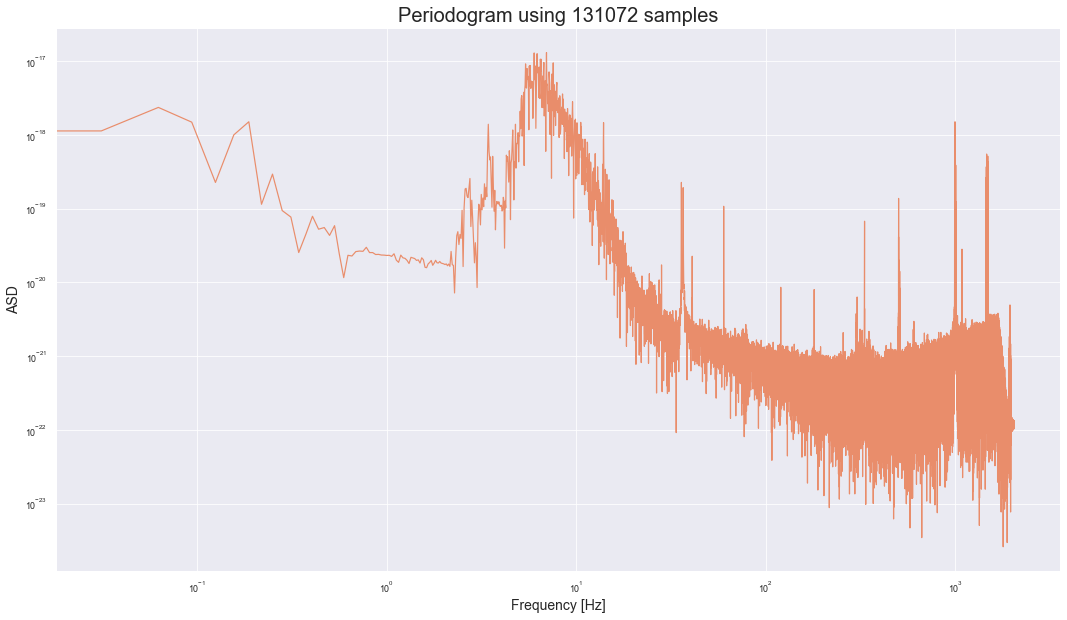

In [102]:
_, test = signal.periodogram(h1_32_samples, window='boxcar', return_onesided=False)
plot_asd(test, 1 / h1_32_ts, f'Periodogram using {len(h1_32_samples)} samples')

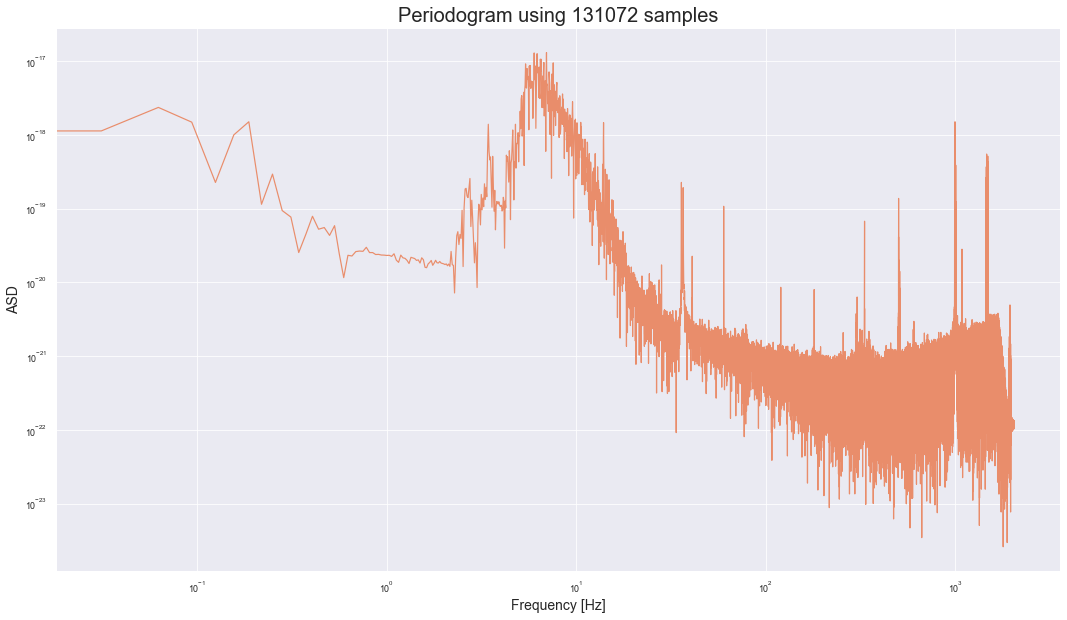

In [103]:
# Compute the periodogram and plot it
h1_32_psd = periodogram(h1_32_samples, window='boxcar', one_sided=False)
plot_asd(h1_32_psd, 1 / h1_32_ts, f'Periodogram using {len(h1_32_samples)} samples')

### Periodogram smoothing

### Periodogram averaging

In [60]:
def periodogram_averaging(x: np.array, window_size: int, overlap: float = 0.0, window: str = 'boxcar') -> np.array:
    """ Apply the welch-bartlett method (averaging periodograms) to estimate a signal's power spectrum.
        @param x Samples of the random signal realization    
        @param window_size Size of the window
        @param overlap Overlapping factor [0.0, 1.0)  
        @param window Type of window
        @return Power spectrum density estimation
    """
    # Validate the type of window
    if type(window) is not str:
        raise ValueError('Window must be a string value, unexpected type of data')
    
    # Validate signal samples
    if type(x) is not np.array and type(x) is not np.ndarray:
        raise ValueError('Signal samples must be np.array, unexpected type of data')
    elif x.ndim > 1:
        raise ValueError('The signal samples argument must be 1D')
        
    # Validate the window size
    if type(window_size) is not int:
        raise ValueError('Window size must be an integer value, unexpected type of data')
    elif window_size < 1 or window_size >= len(x):
        raise ValueError('Window size out of range')
    
    # Validate the overlapping
    if type(overlap) is not float:
        raise ValueError('The overlap must be a decimal value, unexpected type of data')
    elif overlap < 0.0 or overlap >= 1.0:
        raise ValueError('Overlapping factor out of range')
    
    # Compute algorithm parameters based on the arguments passed to the function
    N = len(x)
    L = window_size
    D = int(L * (1 - overlap))
    K = int((N - L + 1) / D) + 1
    
    # Create the periodogram matrix and compute i-th segment periodogram
    periodograms = np.zeros((K, L))
    segment = np.zeros((L))
    for k in range(K):
        segment = x[k * D:k * D + L]
        _, periodograms[k,:] = signal.periodogram(segment, window=window, return_onesided=False)
    # Squash and average periodograms
    return periodograms.sum(axis=0) / K

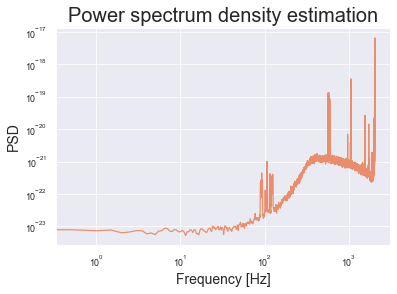

In [68]:
h1_32_psd_averaging = periodogram_averaging(h1_32_samples, 8192, 0.0, window='hanning')

## Estacionariedad
Para la síntesis de un procesamiento adecuado de las señales gravitatorias es necesario poseer más información de la situación, para lo cual es deseable obtener la densidad espectral de potencia de las señales y del ruido. Para esto último, es necesario asumir un modelo teórico que describe al ruido como un proceso aleatorio que se entiende como un ensamble infinito de señales de las cuales en la realidad física se observa una única realización. Dado que no se tiene acceso a la realidad subyacente, con la información incompleta que se posee sólo es posible estimar cómo podría ser el espectro del ruido. La calidad de esta estimación está principalmente gobernada por el carácter de ergodicidad del proceso subyacente, esto quiere decir que si tal proceso fuera ergódico, conocer una única realización es suficiente información para conocer su espectro, ya que es altamente representativa de todo el ensamble. No obstante, no se sabe si el proceso es efectivamente ergódico y aunque lo fuera no se conoce la realización, sino un fragmento de ella, por ende siempre se obtiene una estimación ruidosa.

En conclusión, es condición necesaria que el proceso aleatorio sea estacionario en sentido amplio (WSS) para que sea ergódico y obtener una mejor calidad en la estimación. En esta sección nos proponemos validar tal estacionariedad a partir de las muestras obtenidas.

##### Fuentes de información
* https://machinelearningmastery.com/time-series-data-stationary-python/
* https://towardsdatascience.com/detecting-stationarity-in-time-series-data-d29e0a21e638

In [61]:
from scipy import signal

In [17]:
def signal_segmentation(x: np.array, segment_size: int, overlap: float = 0.0) -> np.array:
    """ Extracts segments of a signal to apply block or window based processing algorithms
        @param x Samples of the random signal realization    
        @param segment_size Size of the segment
        @param overlap Overlapping factor [0.0, 1.0)  
        @return Matrix (segment count x segment size) 
    """
    # Validate signal samples
    if type(x) is not np.array and type(x) is not np.ndarray:
        raise ValueError('Signal samples must be np.array, unexpected type of data')
    elif x.ndim > 1:
        raise ValueError('The signal samples argument must be 1D')
        
    # Validate the window size
    if type(segment_size) is not int:
        raise ValueError('Window size must be an integer value, unexpected type of data')
    elif segment_size < 1 or segment_size >= len(x):
        raise ValueError('Window size out of range')
    
    # Validate the overlapping
    if type(overlap) is not float:
        raise ValueError('The overlap must be a decimal value, unexpected type of data')
    elif overlap < 0.0 or overlap >= 1.0:
        raise ValueError('Overlapping factor out of range')
        
    # Compute parameters for segmentation
    N = len(x)
    L = segment_size
    D = int(L * (1 - overlap))
    K = int((N - L + 1) / D) + 1
    
    # Create the periodogram matrix and compute i-th segment periodogram
    segments = np.zeros((K, L))
    for k in range(K):
        segments[k,:] = x[k * D:k * D + L]
    return segments

In [55]:
def signal_statistics(x: np.array, fs: float, interval_size: int, segment_size: int, overlap: float):
    """ Shows statistical information of a random signal. It partitions the signal into intervals (of interval_size) and plots the
        histogram and power spectrum density estimation for each interval. All plots are overlapped to allow easy comparation of the results
        for each interval, as a way of testing the signal's stationarity.
        @param x Samples 
        @param fs Sampling frequency
        @param interval_size Size of the interval
        @param segment_size Size of the segment used in periodogram averaging
        @param overlap Overlappig factor used in periodogram averaging
    """
    # Segmentation of the signal
    segments = signal_segmentation(x, interval_size)
    
    # Periodogram averaging estimation
    periodograms = np.apply_along_axis(lambda s: periodogram_averaging(s, segment_size)[1:], axis=1, arr=segments)

    # Plotting the psd and the distribution
    fig, ax = plt.subplots(1, 2, figsize=(18, 7))
    ax[0].loglog(np.arange(0, fs / 2, (fs / 2) / periodograms.shape[1]), np.sqrt(periodograms.transpose()))
    ax[0].set_title('Power spectrum density estimation', fontsize=20)
    ax[0].set_xlabel('Frequency [Hz]', fontsize=14)
    ax[0].set_ylabel('PSD', fontsize=14)
    ax[0].grid()
    ax[1].set_title('Probability distribution estimation', fontsize=20)
    ax[1].set_xlabel('Values', fontsize=14)
    ax[1].set_ylabel('Absolute frequency', fontsize=14)
    ax[1].grid()
    for segment in segments:
        sns.histplot(segment, element='poly', fill=False, bins=256, ax=ax[1])

### Análisis de estacionariedad para H1

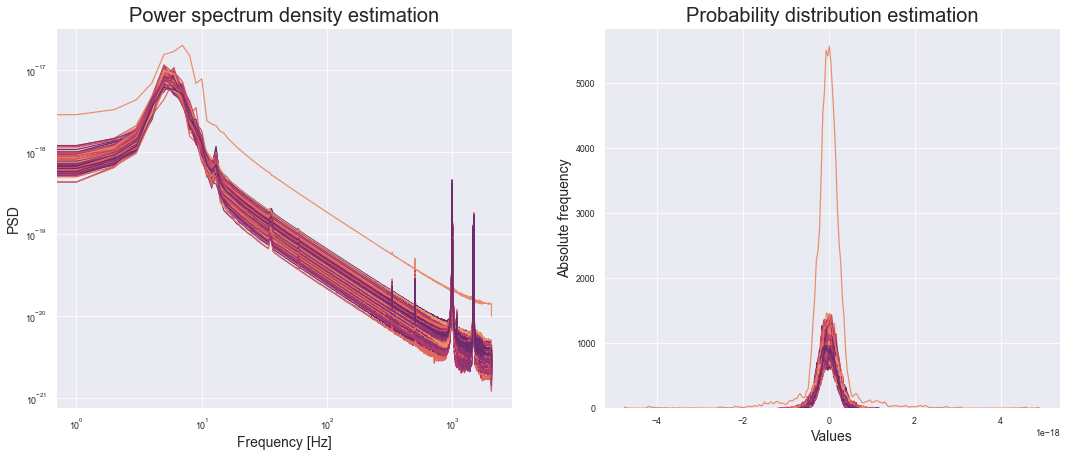

In [58]:
signal_statistics(h1_4096_samples, 1 / h1_4096_ts, 20 * 4096, 4096, 0.0)

### Análisis de estacionariedad para L1

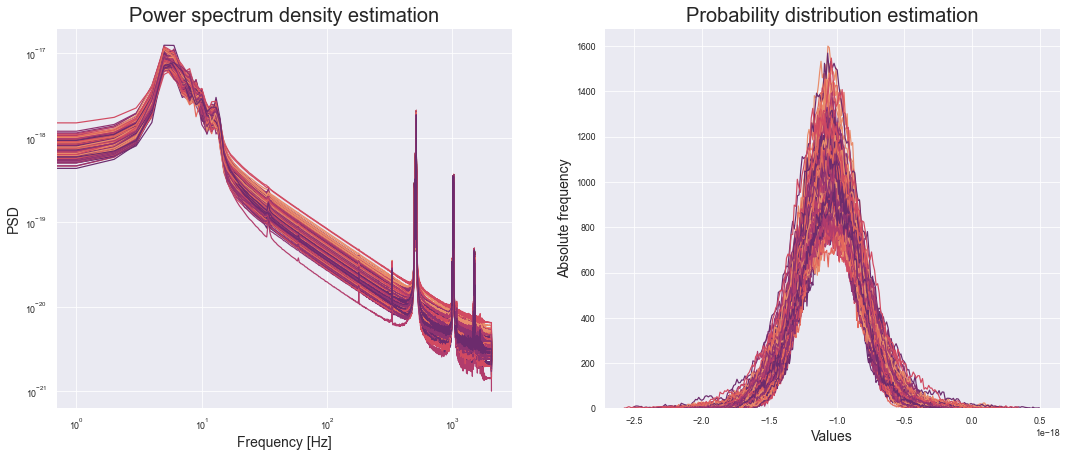

In [59]:
signal_statistics(l1_4096_samples, 1 / l1_4096_ts, 20 * 4096, 4096, 0.0)

### Conclusiones de estacionariedad
Se puede concluir, por observación, que L1 y H1 son estacionarios en un sentido amplio, ya que para diferentes intervalos de tiempo la distribución de probabilidad y la densidad espectral de potencia (o su función de autocorrelación) no cambia, por ende se dice que no depende del tiempo.

### Estimación resultante

### Comparación de estimaciones de H1 y L1

## Whitening

## Ángulo del cono de arribo